# 飞桨常规赛：用户购买预测 7月第7名方案

> 说明：一开始主要使用树模型但效果上较差，后期主要是参考[飞桨常规赛：用户购买预测 3月第4名方案](https://aistudio.baidu.com/aistudio/projectdetail/1077670?channelType=0&channel=0)，在其基础上进行调参优化。

> 在7月获得了该比赛的第7名，该项目主用于代码审核。需注意项目运行最好选择GPU环境，否则会出现内存不足的情况。
鉴于排行榜中出现的较多0分情况，应该是没有看好赛题要求：输出类别标签为0或1而不是分数，需要对结果进行后处理，这点需要特别注意！

> Github地址：https://github.com/hchhtc123/User-purchase-forecast

![](https://ai-studio-static-online.cdn.bcebos.com/10e2eb8a298f42918ce1a4f051c84f04ed251b9baadd463cb444213461704c7c)

**以下为大佬的基线模型，本人仅做了调参优化处理：**

## 赛题介绍
智能营销工具可以帮助商家预测用户购买的行为，本次比赛提供了一份品牌商家的历史订单数据，参赛选手需构建一个预测模型，预估用户人群在规定时间内产生购买行为的概率。
该模型可应用于各种电商数据分析，以及百度电商开放平台， 不仅可以帮助商家基于平台流量，进行商品售卖、支付，还可以通过MarTech技术更精准地锁定核心用户，对用户的购买行为进行预测。

[点击跳转至赛题页面](https://aistudio.baidu.com/aistudio/competition/detail/51)

## 基线介绍
### 运行方式

本次基线基于飞桨PaddlePaddle 2.1版本，若本地运行则可能需要额外安装jupyter notebook环境、pandas模块等。
AI Studio上运行建议使用32G内存的高级版，本地运行同样建议配置较大的内存空间。

#### AI Studio (Notebook)运行

依次运行下方的cell即可，若运行时修改了cell，推荐在右上角重启执行器后再以此运行，避免因内存未清空而产生报错。

#### 本地运行

fork本项目后点击右上角的“文件”——“导出Notebook为ipynb”，下载到本地后在`jupyter notebook`环境即可开始训练，生成的推理结果文件为`result.csv`。

### 设计思想

#### 执行流程

1. 配置预处理数据方案(选手可以自行设计，默认提供用于时间滑窗特征工程和归一化两种方案)
2. 检查数据是否可以正确读取（可省略，若选手自行修改了数据预处理部分，务必检查能否读取后再进行下一步操作）
3. 开始训练
4. 执行预测并产生结果文件

#### 技术方案
在本次赛题中，虽然赛题是一个二分类任务（用户购买、未购买），但从赛题数据看，属于比较典型的时间序列数据，也可以参照以往的线性回归任务的做法处理。 
接下来将介绍技术方案中的一些细节问题以及method流程。

##### label设计
本次赛题反映了一个客观事实——在真实场景应用机器学习/深度学习技术时，通常是没有已经整理好的训练集、验证集、测试集，需要自己设计。

比如赛题中提到，在比赛任务是预测下个月用户是否购买，下个月是哪个月？我们不妨设想自己是个业务经理，现在领导说做个模型，预测下个月你手上的客户是否会流失。所以在这类题目中，下个月就是提供的数据集截止日期之后的一个月。当然，如果比赛要求预测未来7天、未来15天的销售情况，道理也是一样的。

在此类比赛的解决方案中，通常会有个时间滑窗的概念。比如按月进行时间滑窗，本题中数据到2013.8.31，默认提供的数据集划分设计如下（选手也可以自行设计数据集的划分）：
- 训练集：用2013年4-6月的数据预测用户在7月是否购买
- 验证集：用2013年5-7月的数据预测用户在8月是否购买
- 测试集：用2013年6-8月的数据预测用户在9月是否购买

```python
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]
```

##### 时间滑窗特征构建
> 注：更详细的时间滑窗特征工程的方法请参考[用户购买预测时间滑窗特征构建](https://aistudio.baidu.com/aistudio/projectdetail/276829)，本项目做了大幅缩减。

时间滑窗在业务应用上被称为RFM模型，RFM模型最早是用来衡量客户价值和客户创利能力。理解RFM框架的思想是构造统计类特征的基础，其含义为：
- R（Recency）：客户最近一次交易消费时间的间隔。R值越大，表示客户交易发生的日期越久，反之则表示客户交易发生的日期越近。
- F（Frequency）：客户在最近一段时间内交易消费的次数。F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。
- M（Monetary）：客户在最近一段时间内交易消费的金额。M值越大，表示客户价值越高，反之则表示客户价值越低。

也就是说，时间滑窗特征本身是与业务紧密联系的，而在这类时间序列数据的比赛中，滑动时间窗口内的统计指标可以更加丰富，统计值一般会有最大值、最小值、均值、标准差、中位数、极差等。

```python
# 要计算统计指标特征的时间窗口
for i in [14,30,60,91]:
	tmp = get_timespan(df_payment, t2018, i, i)
   # 削去峰值的均值特征
   X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
   # 中位数特征，在本赛题中基本不适用
   # X['median_%s' % i] = tmp.median(axis=1).values
   # 最小值特征，在本赛题中基本不适用
   # X['min_%s' % i] = tmp_1.min(axis=1).values
   # 最大值特征
   X['max_%s' % i] = tmp.max(axis=1).values
   # 标准差特征
   # X['std_%s' % i] = tmp_1.std(axis=1).values
   # 求和特征
   X['sum_%s' % i] = tmp.sum(axis=1).values
```
##### 深度学习模型搭建
参考[使用飞桨重写房价预测模型](https://aistudio.baidu.com/aistudio/projectdetail/366426)和[Martech_track1_beta](https://aistudio.baidu.com/aistudio/projectdetail/510779)搭建三层深度神经网络。需要注意的是，由于神经网络对缺失值和稀疏数据敏感，对送入神经网络的特征需要做筛选。另外，选择哪种神经网络结构效果更好，需要参赛选手进一步探索。
```python
# 构建多层神经网络
class Regressor(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(Regressor, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义三层全连接层，输入维度是最终选取的特征数量，输出维度是1，激活函数为relu
        self.fc1 = Linear(input_dim=41, output_dim=128, act='relu') # 输入层，input dim 为数据维度大小
        self.fc2 = Linear(input_dim=128, output_dim=128, act='relu')
        self.fc3 = Linear(input_dim=128, output_dim=1, act='sigmoid')
    # 网络的前向计算函数
    def forward(self, inputs):
        fc1 = self.fc1(inputs)
        fc2 = self.fc2(fc1)
        x = self.fc3(fc2)
        return x
```

## 数据预处理 - 数据集划分与特征工程

In [1]:
# 导入所需的第三方库
import numpy as np  
import pandas as pd 
from datetime import datetime, date, timedelta
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime as dt
import calendar
import gc
from datetime import date, timedelta
import paddle
import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear
import random

### 加载数据集

In [2]:
# 数据集位置
PATH = './data/data19383/'
train = pd.read_csv(PATH + 'train.csv')
# train = pd.read_csv('./data/data19383/train.csv', usecols=[2, 3, 4, 6, 7, 18])
# set index to ID to avoid droping it later
# 把测试集的id列作为索引，防止误删
test  = pd.read_csv(PATH + 'submission.csv').set_index('customer_id')

In [3]:
# 训练集概况，查看最后面10条
train[['order_detail_id','order_id','order_amount','order_pay_time','is_customer_rate','order_detail_goods_num','order_detail_amount','order_detail_discount','customer_id','goods_id']].tail(10)

,order_detail_id,order_id,order_amount,order_pay_time,is_customer_rate,order_detail_goods_num,order_detail_amount,order_detail_discount,customer_id,goods_id
2306861,3685490,3238357,707.7,2013-01-24 00:24:40,0.0,2.0,179.8,298.2,2826572,1478
2306862,3685491,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,126.9,172.1,2826572,2103
2306863,3685492,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,0.0,29.9,2826572,3153
2306864,3685493,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,74.9,105.0,2826572,1778
2306865,3685494,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,94.9,104.9,2826572,2128
2306866,3685495,3238358,199.0,2013-01-10 19:24:31,0.0,1.0,59.9,139.1,2826573,1173
2306867,3685496,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,0.0,59.9,2826574,2513
2306868,3685497,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,89.9,150.0,2826574,998
2306869,3685498,3238360,168.0,2012-11-11 00:10:37,0.0,1.0,76.9,91.1,2826574,1423
2306870,3685499,3238361,102.0,2013-07-10 14:22:14,0.0,1.0,49.9,52.1,2826574,1043


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


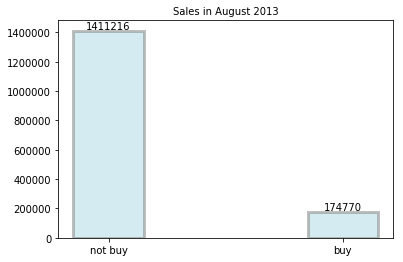

In [4]:
# 查看类别标签分布情况
%matplotlib inline
y = range(1,2)
 
plt.bar(['not buy','buy'], [1585986-174770,174770], alpha=0.5, width=0.3, color='lightblue', edgecolor='grey', lw=3)
plt.title('Sales in August 2013', fontsize=10)
for a, b in zip(['not buy','buy'], [1585986-174770,174770]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

In [5]:
# 对于特别大的文件，我们需要做一些内存检查
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 510.40096282958984 MB
测试集使用内存 24.200225830078125 MB


### 内存优化脚本
- 参考[缓解pandas中DataFrame占用内存过大的问题](https://blog.csdn.net/wj1066/article/details/81124959)
- 效果非常显著，有效避免内存溢出

In [6]:
# @from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65/code
# @liscense: Apache 2.0
# @author: weijian
def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            # print("**************************")
            # print("columns: ", col)
            # print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # Integer does not support NA, therefore Na needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            # print("dtype after", props[col].dtype)
            # print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [7]:
# 数据预处理
# 处理id字段
train['order_detail_id'] = train['order_detail_id'].astype(np.uint32)
train['order_id'] = train['order_id'].astype(np.uint32)
train['customer_id'] = train['customer_id'].astype(np.uint32)
train['goods_id'] = train['goods_id'].astype(np.uint32)
train['goods_class_id'] = train['goods_class_id'].astype(np.uint32)
train['member_id'] = train['member_id'].astype(np.uint32)
# 处理状态字段，这里同时处理空值，将空值置为0
train['order_status'] = train['order_status'].astype(np.uint8)
train['goods_has_discount'] = train['goods_has_discount'].astype(np.uint8)
train["is_member_actived"].fillna(0, inplace=True)
train["is_member_actived"]=train["is_member_actived"].astype(np.int8)
train["member_status"].fillna(0, inplace=True)
train["member_status"]=train["member_status"].astype(np.int8)
train["customer_gender"].fillna(0, inplace=True)
train["customer_gender"]=train["customer_gender"].astype(np.int8)
train['is_customer_rate'] = train['is_customer_rate'].astype(np.uint8)
train['order_detail_status'] = train['order_detail_status'].astype(np.uint8)
# 处理日期
train['goods_list_time']=pd.to_datetime(train['goods_list_time'],format="%Y-%m-%d")
train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
train['goods_delist_time']=pd.to_datetime(train['goods_delist_time'],format="%Y-%m-%d")
# 检查内存使用
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 349.8006982803345 MB
测试集使用内存 24.200225830078125 MB


### 构造时间滑窗特征

#### 每日付款金额

In [8]:
# 将用户下单金额按天进行汇总
# df = train[train.order_status<101][train.order_pay_time>'2013-02-01']
df = train[train.order_pay_time>'2013-02-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment = df[['customer_id','date','order_total_payment']]

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


注意，成功交易的客户数量不等于全部客户数量，说明有相当一部分客户虽然下过单，但是没有成功的订单，那么这些客户自然应当算在训练集之外。
数据合并时，由于`test.csv`中，已经设置了默认0值，只需要和训练后的预测标签做一个`left join`就可以了

In [9]:
df_payment = df_payment.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [10]:
df_payment = df_payment.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)
df_payment.columns = df_payment.columns.get_level_values(1)

#### 每日购买商品数量

In [11]:
df_goods = df[['customer_id','date','order_total_num']]
df_goods = df_goods.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']
df_goods.reset_index(inplace=True)
df_goods = df_goods.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.columns = df_goods.columns.get_level_values(1)

该场景每天都有成交记录，这样就不需要考虑生成完整时间段填充的问题

In [12]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

1. 构造dataset这里有个取巧的地方，因为要预测的9月份除了开学季以外不是非常特殊的月份，因此主要考虑近期的因素，数据集的开始时间也是2月1日，尽量避免了双十一、元旦假期的影响，当然春节假期继续保留。同时，构造数据集的时候保留了customer_id，主要为了与其它特征做整合。
2. 通过一个函数整合付款金额和商品数量的时间滑窗，主要是因为分开做到时候合并占用内存更大，并且函数最后在返回值处做了内存优化，用时间代价尽可能避免内存溢出。

In [13]:
def prepare_dataset(df_payment, df_goods, t2018, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    # 消费特征
    print('Preparing payment feature...')
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        # X['diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s' % i] = tmp_1.mean(axis=1).values
        # X['median_%s' % i] = tmp.median(axis=1).values
        # X['min_%s' % i] = tmp_1.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        # X['std_%s' % i] = tmp_1.std(axis=1).values
        X['sum_%s' % i] = tmp.sum(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018 + timedelta(days=-7), i, i)
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        # X['median_%s_2' % i] = tmp.median(axis=1).values
        # X['min_%s_2' % i] = tmp_2.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        # X['std_%s_2' % i] = tmp_2.std(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp != 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp != 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp != 0) * np.arange(i, 0, -1)).max(axis=1).values

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, t2018, i*30, 30).sum(axis=1).values
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [21,49,84]:
            tmp = get_timespan(df_goods, t2018, i, i)
            # X['goods_diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay' % i] = (tmp_1 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s' % i] = tmp.median(axis=1).values
            # X['goods_min_%s' % i] = tmp_1.min(axis=1).values
            X['goods_max_%s' % i] = tmp.max(axis=1).values
            # X['goods_std_%s' % i] = tmp_1.std(axis=1).values
            X['goods_sum_%s' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018 + timedelta(weeks=-1), i, i)
            # X['goods_diff_%s_mean_2' % i] = tmp_2.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay_2' % i] = (tmp_2 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s_2' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s_2' % i] = tmp.median(axis=1).values
            # X['goods_min_%s_2' % i] = tmp_2.min(axis=1).values
            X['goods_max_%s_2' % i] = tmp.max(axis=1).values
            X['goods_sum_%s_2' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018, i, i)
            X['goods_has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
            X['goods_last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
            X['goods_first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values


    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, t2018, i*28, 28).sum(axis=1).values

    X = pd.DataFrame(X)
    
    reduce_mem_usage(X)
    
    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        X['label'] = df_goods[pd.date_range(t2018, periods=30)].max(axis=1).values
        X['label'][X['label'] > 0] = 1
        return X
    return X

In [14]:
# 需要一定的时间，请耐心等待
num_days = 4
t2017 = date(2013, 7, 1)
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    # X_tmp, y_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = pd.concat([X_tmp], axis=1)

    X_l.append(X_tmp)
    # y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
# y_train = np.concatenate(y_l, axis=0)

del X_l, y_l

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
X_test = prepare_dataset(df_payment, df_goods, date(2013, 9, 1), is_train=False)
X_test = pd.concat([X_test], axis=1)

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


### 中间结果保存

In [16]:
X_train.to_csv('X_train.csv')

In [17]:
X_test.to_csv('X_test.csv')

## 训练&推理 - 训练配置以及训练
### 加载特征工程结果

In [18]:
# X_train = pd.read_csv('X_train.csv',usecols=['max_30','has_sales_days_in_last_30','first_has_sales_day_in_last_60','goods_sum_49','label'])
X_train = pd.read_csv('X_train.csv')
X_train.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)

In [19]:
X_val = pd.read_csv('X_test.csv')
X_val.drop('Unnamed: 0', inplace=True, axis=1)

In [20]:
X_test = pd.read_csv('X_test.csv')
# X_test = pd.read_csv('X_test.csv',usecols=['max_30','has_sales_days_in_last_30','first_has_sales_day_in_last_60','goods_sum_49'])
X_test.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)

In [21]:
X_train.head()

,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,mean_91_decay,...,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
1,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
2,0.0,0.0,0.0,3.537,39.9,39.9,3.537,39.9,39.9,3.537,...,1,24,24,1,24,24,1,0,0,0.0
3,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,1.0
4,0.0,0.0,0.0,0.000,0.0,0.0,2.530,98.9,197.8,2.530,...,1,37,37,2,37,56,0,2,0,1.0


### 选取参与训练的特征

In [22]:
print(X_train.columns)

Index(['mean_14_decay', 'max_14', 'sum_14', 'mean_30_decay', 'max_30',
       'sum_30', 'mean_60_decay', 'max_60', 'sum_60', 'mean_91_decay',
       'max_91', 'sum_91', 'mean_14_decay_2', 'max_14_2', 'mean_30_decay_2',
       'max_30_2', 'mean_60_decay_2', 'max_60_2', 'mean_91_decay_2',
       'max_91_2', 'has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91',
       'first_has_sales_day_in_last_91', 'day_1_2018', 'day_2_2018',
       'day_3_2018', 'goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21

In [23]:
X_train = X_train[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018','label']]
X_test = X_test[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018']]

In [24]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

### 数据归一化

In [25]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [26]:
# 前面标签也被归一化了，还原
X_train['label'][X_train['label'] > 0] = 1

In [27]:
print(len(X_train.columns))

42


In [28]:
# 数据分割 9:1
def load_data(df,istrain):
    # data = np.fromfile(datafile)
    data = df

    feature_num = len(data.columns)
    # 将原始数据进行Reshape
    data = np.array(data)
    data = data.reshape([-1, feature_num])
    
    # 训练集和测试集的划分比例
    #ratio = 0.9
    if istrain == True:
        ratio = 0.9
        offset = int(data.shape[0] * ratio)
        training_data = data[:offset]
        test_data = data[offset:]
    else:
        training_data = data
        test_data = None

    return training_data, test_data

In [29]:
# 加载处理后的数据
training_data, test_data = load_data(X_train,True)
print('train set done.')

pre_data, none = load_data(X_test,False)
print('test set done.')

train set done.
test set done.


### 搭建多层神经网络

In [30]:
# 构建3层神经网络
class Regressor(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(Regressor, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义三层全连接层，输出维度是1，激活函数为relu
        self.fc1 = Linear(input_dim=41, output_dim=128, act='relu') # 输入层，input dim 为数据维度大小
        self.fc2 = Linear(input_dim=128, output_dim=128, act='relu')
        self.fc3 = Linear(input_dim=128, output_dim=1, act='sigmoid')
    # 网络的前向计算函数
    def forward(self, inputs):
        fc1 = self.fc1(inputs)
        fc2 = self.fc2(fc1)
        x = self.fc3(fc2)
        return x

**调参：**   学习率和优化器也是个非常重要的参数

In [31]:
with fluid.dygraph.guard():
    # 声明定义好的线性回归模型
    model = Regressor("Regressor")
    # 开启模型训练模式
    model.train()
    # 定义优化算法，这里使用Adam Optimizer
    # 学习率设置为0.00001
    opt = fluid.optimizer.Adam(learning_rate=1e-5, parameter_list=model.parameters())

### 定义损失函数

In [32]:
# 使用类别权重对数据不平衡问题进行处理
def wce_loss(pred, label, w=48, epsilon=1e-05): # w 是给到 y=1 类别的权重，越大越重视
    label = fluid.layers.clip(label, epsilon, 1-epsilon)
    pred = fluid.layers.clip(pred, epsilon, 1-epsilon)

    loss = -1 * (w * label * fluid.layers.log(pred) + (1 - label) * fluid.layers.log(1 - pred))
    loss = fluid.layers.reduce_mean(loss)
    return loss

### 开始训练

**调参：**  EPOCH_NUM、BATCH_SIZE

In [33]:
# 模型训练和保存
with dygraph.guard(fluid.CPUPlace()):
    EPOCH_NUM = 7   # 设置外层循环次数,初始为6
    BATCH_SIZE = 4096  # 设置batch大小，初始为4096。
    
    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]).astype('float32') # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]).astype('float32') # 获得当前批次训练标签

            # 将numpy数据转为飞桨动态图variable形式
            buyer_features = dygraph.to_variable(x)
            result = dygraph.to_variable(y)
            
            # 前向计算
            predicts = model(buyer_features)
            # loss = fluid.layers.log_loss(predicts, prices)
            loss = wce_loss(predicts, result)
            avg_loss = fluid.layers.mean(loss)
            
            # logloss = fluid.layers.log_loss(predicts, prices)

            if iter_id % 20 == 0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
                # print(predicts)
     
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.minimize(avg_loss)
            # 清除梯度
            model.clear_gradients()
    # 保存模型
    fluid.save_dygraph(model.state_dict(), 'MLP_model')
    print("模型保存成功，模型参数保存在MLP_model中")

epoch: 0, iter: 0, loss is: [4.42944]
epoch: 0, iter: 20, loss is: [4.258627]
epoch: 0, iter: 40, loss is: [4.103505]
epoch: 0, iter: 60, loss is: [4.135817]
epoch: 0, iter: 80, loss is: [4.0722103]
epoch: 0, iter: 100, loss is: [3.822112]
epoch: 0, iter: 120, loss is: [4.0930786]
epoch: 0, iter: 140, loss is: [3.872131]
epoch: 0, iter: 160, loss is: [3.8494742]
epoch: 0, iter: 180, loss is: [4.004653]
epoch: 0, iter: 200, loss is: [3.912506]
epoch: 0, iter: 220, loss is: [3.6657]
epoch: 0, iter: 240, loss is: [3.5358813]
epoch: 0, iter: 260, loss is: [3.611012]
epoch: 0, iter: 280, loss is: [3.4558754]
epoch: 0, iter: 300, loss is: [3.4343693]
epoch: 0, iter: 320, loss is: [3.5103385]
epoch: 0, iter: 340, loss is: [3.619368]
epoch: 0, iter: 360, loss is: [3.47288]
epoch: 0, iter: 380, loss is: [3.4157434]
epoch: 0, iter: 400, loss is: [3.5165477]
epoch: 0, iter: 420, loss is: [3.480499]
epoch: 0, iter: 440, loss is: [3.307901]
epoch: 0, iter: 460, loss is: [3.2342353]
epoch: 0, iter: 

### 生成提交文件

In [34]:
with dygraph.guard():
    # 参数为保存模型参数的文件地址
    model_dict, _ = fluid.load_dygraph('MLP_model')
    model.load_dict(model_dict)
    model.eval()
    pre = pre_data.astype('float32')
    # 将数据转为动态图的variable格式
    pre = dygraph.to_variable(pre)
    results = model(pre)

    print("Inference result is {}".format(results.numpy()[:5]))

Inference result is [[0.64143705]
 [0.923506  ]
 [0.92082185]
 [0.6048201 ]
 [0.5992387 ]]


In [35]:
print(len(results))

685471


In [36]:
results.numpy().flatten()[:6]

array([0.64143705, 0.923506  , 0.92082185, 0.6048201 , 0.5992387 ,
       0.9224564 ], dtype=float32)

In [37]:
sub = pd.read_csv('X_test.csv', usecols=['customer_id'])

In [38]:
df_preds = pd.DataFrame(
{    "customer_id": sub.customer_id, 
    "pred": results.numpy().flatten()}
)

In [39]:
df_preds.head()

,customer_id,pred
0,1000014,0.641437
1,1000034,0.923506
2,1000046,0.920822
3,1000069,0.604820
4,1000105,0.599239


In [40]:
sub = pd.read_csv('data/data19383/submission.csv')

In [41]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585986 entries, 0 to 1585985
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   customer_id  1585986 non-null  int64  
 1   result       1585986 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 24.2 MB


In [42]:
submission = pd.merge(sub, df_preds, on='customer_id', how='left')
submission.fillna(0,inplace=True)
submission = submission[['customer_id','pred']]
submission.rename(columns={'customer_id':'customer_id','pred':'result'}, inplace=True)

In [43]:
submission.head()

,customer_id,result
0,1000000,0.000000
1,1000014,0.641437
2,1000034,0.923506
3,1000046,0.920822
4,1000048,0.000000


In [44]:
# 将概率值转换为用户是否购买的标签
# 由于输出的为0或1，设置阈值为0.5
def f(x):
    if x <= 0.5:
        return 0
    if x > 0.5:
        return 1
    return x

In [45]:
submission['result'] = submission['result'].map(f)

In [46]:
# 生成结果文件
submission.to_csv('result.csv',index=False)

**预测结束后提交result.csv文件即可！**

![](https://ai-studio-static-online.cdn.bcebos.com/54d0499de8d54a8f90de35afbfd48e52ef35863775ab4e72974c8f21d65f2797)

代码导出：

![](https://ai-studio-static-online.cdn.bcebos.com/c9f4d5ed4e9d444c8908c4d243444b275ac9854f15d744aba24dd6e62bf110bd)